In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import re
import matplotlib.pyplot as plt
%matplotlib inline

# Формулы

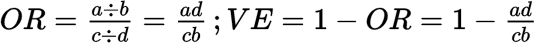





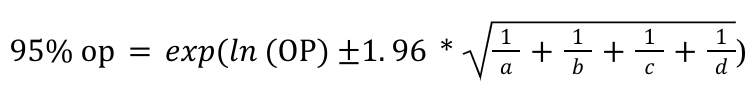

In [2]:
# Odds Ratio CI calculation
def get_OR_CI(OR, a,b,c,d):
    delta = 1.96*np.sqrt(1/a+1/b+1/c+1/d)
    CI_min = np.exp(np.log(OR)-delta)
    CI_max = np.exp(np.log(OR)+delta)
    return (CI_min, CI_max)

def get_VE(a,b,c,d):
    OR = (a/b)/(c/d)
    OR_CI_min, OR_CI_max = get_OR_CI(OR,a,b,c,d)
    VE = (1-OR)*100
    VE_CI_min = (1-OR_CI_max)*100 # note min-max swap
    VE_CI_max = (1-OR_CI_min)*100 # note min-max swap
    return (VE, VE_CI_min, VE_CI_max)

def append_VE(df, a_id, b_id, c_id, d_id, name='1'):
    df=df.copy()
    df["VE_{}".format(name)]=       get_VE(df[a_id],\
                                           df[b_id],\
                                           df[c_id],\
                                           df[d_id])[0]
    df["VE_{}_CI_min".format(name)]=get_VE(df[a_id],\
                                           df[b_id],\
                                           df[c_id],\
                                           df[d_id])[1]
    df["VE_{}_CI_max".format(name)]=get_VE(df[a_id],\
                                           df[b_id],\
                                           df[c_id],\
                                           df[d_id])[2]
    return df

# Чтение данных

In [3]:
# Таблица заболевших:
df_cases = pd.read_csv('tables_temp/df_cases.csv')

# Таблица вакцинированных:
df_vaccinated_Moscow = pd.read_csv('tables_temp/vaccinations_Moscow_cumulative_adjusted.csv', \
                                   header=[0,1],\
                                   index_col=0,\
                                   parse_dates=True,\
                                   dayfirst=True)

# Таблица численности демографических групп
df_demographics = pd.read_csv('tables_temp/demographics_Moscow_age_groups.csv', index_col=0)

# Таблица серопревалентности (количество неиммунных) по возрастным группам по Dolzhikova et al., 2021
df_seroprevalence = pd.read_csv('tables_temp/df_seroprevalence.csv')

# Расчет

## 1. Соединяем таблицы заболеваемости, вакцинаций, демографии и серопревалентности

На основе таблице заболеваемости составляем основную таблицу, по которой будет рассчитываться OR - `df`.

- Переводим статус вакцинации в колонки


In [4]:
df = df_cases.drop(columns='comment')\
        .set_index(['table_id', 'month', 'age_group', 'vaccine_type','outcome', 'vaccination_status'])\
        .unstack()['cases'].reset_index()

- убираем данные по Ковиваку - их слишком мало.

In [5]:
df = df[df['vaccine_type']!='kovivac'].reset_index(drop=True)

- Добавляем общую численность соответствующей возрастной когорты из демографической таблицы


In [10]:
df = pd.merge(df, df_demographics, on='age_group', how='left')

- Добавляем количество вакцинированных на соответствующий месяц как Спутником, так и Эпиваком и "всеми" вакцинами
(это Спутник и Эпивак, остальных исчезающе мало). 

**Внимание:** для подсчета числа вакцинированных берем начало месяца - **1 июня и 1 июля**. Можно делать так или иначе.


In [11]:
# добавляем колонку с названием месяца 
df_vaccinated_Moscow['month'] = [i.strftime('%B').lower() for i in df_vaccinated_Moscow.index]

# достаем данные за начало двух месяцев - июня и июля
df_vaccinated_Moscow_jun_jul = df_vaccinated_Moscow\
                                    .filter(regex='2021-0[6,7]-01', axis=0)\
                                    .set_index('month', drop=True)\
                                    .stack()\
                                    .reset_index()\
                                    .rename(columns={"epivac":"epivac_all","sputnik":"sputnik_all"})

# создаем дополнительный столбец двух вакцин
df_vaccinated_Moscow_jun_jul['all_vaccinated'] = df_vaccinated_Moscow_jun_jul['epivac_all']\
                                                 + df_vaccinated_Moscow_jun_jul['sputnik_all']

# добавим дополнительную агрегированную возрастную группу 51-100

f1 = df_vaccinated_Moscow_jun_jul['age_group']=='51-70'
f2 = df_vaccinated_Moscow_jun_jul['age_group']=='71-100'
df_temp = pd.concat([df_vaccinated_Moscow_jun_jul[f1|f2].groupby(['month']).sum().reset_index(),\
           pd.DataFrame({'age_group':['51-100','51-100']})],\
           axis=1)
# добавляем агрегированную группу к таблице
df_vaccinated_Moscow_jun_jul = pd.concat([df_vaccinated_Moscow_jun_jul, df_temp]).reset_index(drop=True)
# результат
df_vaccinated_Moscow_jun_jul

,month,age_group,epivac_all,sputnik_all,all_vaccinated
0,june,18-50,3648,711347,714995
1,june,51-70,3427,512338,515765
2,june,71-100,773,129466,130239
3,july,18-50,27529,879731,907260
4,july,51-70,17910,580664,598574
5,july,71-100,3206,138974,142180
6,july,51-100,21116,719638,740754
7,june,51-100,4200,641804,646004


In [12]:
df = pd.merge(df,
              df_vaccinated_Moscow_jun_jul,
              on=['month', 'age_group']).sort_values(['table_id', 'month', 'age_group'])

In [13]:
df.tail()

,table_id,month,age_group,vaccine_type,outcome,V0,V1,V2,population,epivac_all,sputnik_all,all_vaccinated
11,table_2,july,51-70,sputnik,4-severe,1819.0,NaN,92.0,3284276,17910,580664,598574
16,table_2,july,71-100,epivac,4-severe,2418.0,NaN,30.0,1422425,3206,138974,142180
17,table_2,july,71-100,sputnik,4-severe,2418.0,NaN,151.0,1422425,3206,138974,142180
22,table_3,june,18-50,unknown,5-lethal,158.0,NaN,1.0,5760116,3648,711347,714995
31,table_3,june,51-100,unknown,5-lethal,1700.0,NaN,70.0,4706701,4200,641804,646004


## 2. Считаем контрольные группы отдельно для случаев, когда вакцина известна (`table_2`) и когда не известна

Разбиваем на две таблицы

In [14]:
table_1 = df[df['table_id']!='table_2'].copy()
table_2 = df[df['table_id']=='table_2'].copy()

### 2.1 Случай когда вакцина не известна, `table_1` и `table_3`

- Добавляем первую контрольную группу: население в группе минус число вакцинированных

In [15]:
table_1['cg_1'] = table_1.population-table_1.all_vaccinated

- Добавляем вторую контрольную группу - количество неиммунных из Dolzhikova et al., 2021

**Внимание:** неиммунные - это июльские значения (*did not have specific antibodies at the beginning of July*), здесь они используются для обоих месяцев, как июня, так и июля

In [16]:
table_1 =  pd.merge( table_1,\
                     df_seroprevalence\
                     .drop(columns='month')\
             .rename(columns={'all_nonimmune':'cg_2'}),\
             on='age_group',\
             how='left')

table_1.tail()

,table_id,month,age_group,vaccine_type,outcome,V0,V1,V2,population,epivac_all,sputnik_all,all_vaccinated,cg_1,cg_2
21,table_1,june,71-100,unknown,2-light,6221.0,318.0,1701.0,1422425,773,129466,130239,1292186,831713
22,table_1,june,71-100,unknown,3-medium,5151.0,191.0,606.0,1422425,773,129466,130239,1292186,831713
23,table_1,june,71-100,unknown,4-severe,3153.0,75.0,174.0,1422425,773,129466,130239,1292186,831713
24,table_3,june,18-50,unknown,5-lethal,158.0,NaN,1.0,5760116,3648,711347,714995,5045121,2947963
25,table_3,june,51-100,unknown,5-lethal,1700.0,NaN,70.0,4706701,4200,641804,646004,4060697,2621922


### 2.2 Случай когда вакцина известна, `table_2`

- для каждой вакцины делаем столбец с релевантным количеством вакцинированных именно этой вакциной - `vaccinated_relevant`

In [17]:
table_2_sputnik =   table_2[table_2['vaccine_type']=='sputnik']\
                    .drop(columns=['epivac_all'])\
                    .rename(columns={'sputnik_all':'vaccinated_relevant'})

table_2_epivac =   table_2[table_2['vaccine_type']=='epivac']\
                    .drop(columns=['sputnik_all'])\
                    .rename(columns={'epivac_all':'vaccinated_relevant'})
table_2 = pd.concat([table_2_sputnik,table_2_epivac]).reset_index(drop=True)

- первая контрольная группа — **вычитаем всех вакцинированных**, не только той же вакциной

In [18]:
table_2['cg_1'] = table_2.population-table_2.all_vaccinated

- вторая контрольная группа - ее берем из таблицы серопревалентных

In [19]:
table_2 =    pd.merge(table_2,\
                     df_seroprevalence\
                     .drop(columns='month')\
                     .rename(columns={'all_nonimmune':'cg_2'}),\
                     on='age_group',\
                     how='left')

table_2

,table_id,month,age_group,vaccine_type,outcome,V0,V1,V2,population,vaccinated_relevant,all_vaccinated,cg_1,cg_2
0,table_2,july,18-50,sputnik,4-severe,645.0,NaN,13.0,5760116,879731,907260,4852856,2947963
1,table_2,july,51-70,sputnik,4-severe,1819.0,NaN,92.0,3284276,580664,598574,2685702,1790209
2,table_2,july,71-100,sputnik,4-severe,2418.0,NaN,151.0,1422425,138974,142180,1280245,831713
3,table_2,july,18-50,epivac,4-severe,645.0,NaN,7.0,5760116,27529,907260,4852856,2947963
4,table_2,july,51-70,epivac,4-severe,1819.0,NaN,24.0,3284276,17910,598574,2685702,1790209
5,table_2,july,71-100,epivac,4-severe,2418.0,NaN,30.0,1422425,3206,142180,1280245,831713


## 3. Наконец, вычисляем эффективность для разных случаев и контрольных групп

- когда вакцина не известна

In [20]:
table_1 = append_VE(table_1, 'V2', 'all_vaccinated', 'V0', 'cg_1', 'cg1')
table_1 = append_VE(table_1, 'V2', 'all_vaccinated', 'V0', 'cg_2', 'cg2')
table_1.tail()

,table_id,month,age_group,vaccine_type,outcome,V0,V1,V2,population,epivac_all,sputnik_all,all_vaccinated,cg_1,cg_2,VE_cg1,VE_cg1_CI_min,VE_cg1_CI_max,VE_cg2,VE_cg2_CI_min,VE_cg2_CI_max
21,table_1,june,71-100,unknown,2-light,6221.0,318.0,1701.0,1422425,773,129466,130239,1292186,831713,-171.286443,-186.318572,-157.043521,-74.612990,-84.291203,-65.443037
22,table_1,june,71-100,unknown,3-medium,5151.0,191.0,606.0,1422425,773,129466,130239,1292186,831713,-16.725315,-27.000237,-7.281682,24.869979,18.255748,30.949028
23,table_1,june,71-100,unknown,4-severe,3153.0,75.0,174.0,1422425,773,129466,130239,1292186,831713,45.246832,36.211453,53.002387,64.758230,58.942405,69.750241
24,table_3,june,18-50,unknown,5-lethal,158.0,NaN,1.0,5760116,3648,711347,714995,5045121,2947963,95.534074,68.097932,99.374821,97.390472,81.358994,99.634696
25,table_3,june,51-100,unknown,5-lethal,1700.0,NaN,70.0,4706701,4200,641804,646004,4060697,2621922,74.117007,67.127390,79.620440,83.287798,78.774700,86.841284


- когда вакцина известна

In [21]:
table_2 = append_VE(table_2, 'V2', 'vaccinated_relevant', 'V0', 'cg_1', 'cg1')
table_2 = append_VE(table_2, 'V2', 'vaccinated_relevant', 'V0', 'cg_2', 'cg2')
table_2

,table_id,month,age_group,vaccine_type,outcome,V0,V1,V2,population,vaccinated_relevant,all_vaccinated,cg_1,cg_2,VE_cg1,VE_cg1_CI_min,VE_cg1_CI_max,VE_cg2,VE_cg2_CI_min,VE_cg2_CI_max
0,table_2,july,18-50,sputnik,4-severe,645.0,NaN,13.0,5760116,879731,907260,4852856,2947963,88.881885,80.747566,93.579385,93.246082,88.304724,96.099673
1,table_2,july,51-70,sputnik,4-severe,1819.0,NaN,92.0,3284276,580664,598574,2685702,1790209,76.606885,71.155801,81.027804,84.406846,80.773283,87.353720
2,table_2,july,71-100,sputnik,4-severe,2418.0,NaN,151.0,1422425,138974,142180,1280245,831713,42.471880,32.185605,51.197905,62.626774,55.944064,68.295805
3,table_2,july,18-50,epivac,4-severe,645.0,NaN,7.0,5760116,27529,907260,4852856,2947963,-91.313358,-302.955577,9.169142,-16.217069,-144.783389,44.823024
4,table_2,july,51-70,epivac,4-severe,1819.0,NaN,24.0,3284276,17910,598574,2685702,1790209,-97.852152,-196.042221,-32.229363,-31.882355,-97.333107,11.859922
5,table_2,july,71-100,epivac,4-severe,2418.0,NaN,30.0,1422425,3206,142180,1280245,831713,-395.443949,-611.358814,-245.064546,-221.865872,-362.136307,-124.171176


## 4. Сохраняем результат

In [22]:
table_1.to_csv('tables_out/table_1_all_vaccines.csv', index=False)
table_2.to_csv('tables_out/table_2_by_vaccine_type.csv', index=False)
pd.concat([table_1, table_2])\
        .drop(columns=['epivac_all', 'sputnik_all','vaccinated_relevant'])\
        .to_csv('tables_out/result_VE.csv', index=False)

In [41]:
pd.Series(\
{'table_id':'идентификатор таблицы',\
'month':'месяц: к которому относятся данные NB: НЕ тот: в котором получены данные',\
'age_group':'возрастная когорта',\
'vaccine_type':'тип вакцины, неуточненная: спутник, эпивак, ковивак',\
'outcome':'исход заболевания',\
'V0':'количество невакцинированных среди случаев заболевания или инфекции',\
'V1':'количество вакцинированных одной дозой среди случаев заболевания или инфекции',\
'V2':'количество полностью вакцинированных среди случаев заболевания или инфекции',\
'population':'количество человек в возрастной когорте',\
'epivac_all':'количество вакцинированных ЭпиВакКороной на данный месяц в данной когорте',\
'sputnik_all':'количество вакцинированных Спутник V на данный месяц в данной когорте',\
'all_vaccinated':'сумма вакцинированных ЭпиВакКороной и Спутником на данный месяц в данной когорте',\
'vaccinated_relevant': 'только для table_2 - общее количество вакцинированных для данной вакцины для данной когорты на данный месяц',\
'cg_1':'контрольная группа 1 - незаболевшие невакцинированные',\
'cg_2':'контрольная группа 2 - незаболевшие серонегативные по серомониторингу',\
'VE_cg1':'эффективность вакцины посчитанная с контрольной группой 1',\
'VE_cg1_CI_min':'нижняя граница доверительного интервала VE_cg1',\
'VE_cg1_CI_max':'верхняя граница доверительного интервала VE_cg1',\
'VE_cg2':'эффективность вакцины посчитанная с контрольной группой 2',\
'VE_cg2_CI_min':'нижняя граница доверительного интервала VE_cg2',\
'VE_cg2_CI_max':'верхняя граница доверительного интервала VE_cg2'})\
.to_csv('tables_out/columns_description.csv')

In [42]:
!ls tables_out

columns_description.csv  table_1_all_vaccines.csv
result_VE.csv		 table_2_by_vaccine_type.csv
